In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

In [2]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda:0


In [3]:
runs_list = next(os.walk('./Data/Images'))[1]

In [4]:
path = "./Data/Labels.csv"
header = ['Run','AD']
Labelsdf = pd.read_csv(path, names=header, usecols=[1,2], skiprows=1, index_col=False)

In [5]:
labels_dict = dict(zip(Labelsdf.Run, Labelsdf.AD))

In [ ]:
import re

img_dir = "./Data/Images"
#low_bound = 100
#high_bound = 200
img_scale = 1
depth_scale = 33

#list of tuples (image data, AD)
train_data, valid_data, test_data = [], [], []
for run in runs_list:
    # print(run)
    run_dir = os.path.join(img_dir, run)
    run_imgs = []
    for filename in os.listdir(run_dir):
        img_num = int(filename[-7:-4])
        if (120 <= img_num < 199):
            #print(run)
            img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
            break
        
    
            
plt.imshow(img_slice)
plt.show()
img_slice = img_slice[80:176,40:136]
plt.imshow(img_slice)
plt.show()

In [ ]:
len(runs_list)

In [ ]:
import re

# Images of 96, 96, 48 from 256, 176, 256

# Crop in the x and y direction (get center/hippocampi area)
# [80:176, 40:136, ]

img_dir = "./Data/Images"
#low_bound = 100
#high_bound = 200
#img_scale = 1
depth_scale = 2

#list of tuples (image data, AD)
train_data, valid_data, test_data = [], [], []
for run in runs_list:
    #print(run)
    run_dir = os.path.join(img_dir, run)
    run_imgs = []
    for filename in os.listdir(run_dir):
        img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
        # if image is square? IF DO THIS, NEED TO ACCOUNT FOR CENTER OFF SET (176 X 240)
        if  img_slice is None or img_slice.shape[0] == img_slice.shape[1]:
            print(run)
            break
        img_num = int(filename[-7:-4])
        if (100 <= img_num < 196):
            img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
            #img_slice = cv2.resize(img_slice, (0,0), fx=1/img_scale, fy=1/img_scale, interpolation=cv2.INTER_AREA)
            img_slice = img_slice[80:176,40:136]
            # normalize pixel intensity to range of 0 and 1
            img_slice = img_slice/256
            run_imgs.append(img_slice)

    if len(run_imgs) == 0 or len(run_imgs) != 96:
        print(run)
        continue
            
    temp_arr = np.array(run_imgs)
    
    final_slices = []
    #print(temp_arr.shape[2])
    
    for y in range(temp_arr.shape[2]):
        xz_pane = temp_arr[:, :, y]
        scaled_xz = cv2.resize(xz_pane, (0, 0), fy=1/depth_scale, fx=1, interpolation=cv2.INTER_AREA)
        final_slices.append(scaled_xz)
    
    if not len(final_slices[0]) == 48:
        print(run)
        continue
    
    final_array = torch.from_numpy(np.dstack(final_slices)).float()
    #print(final_array.shape)
    if run in labels_dict:
        run_tuple = (final_array.unsqueeze(0), labels_dict[run])
    else:
        continue
    
    subject_regex = re.compile("OAS(?P<order>[0-9]+)")
    subject = subject_regex.search(run).group(1)
    
    if int(subject[-1]) < 6:
        train_data.append(run_tuple)
    elif 6 <= int(subject[-1]) <=7:
        valid_data.append(run_tuple)
    elif 8 <= int(subject[-1]) <= 9:
        test_data.append(run_tuple)
    
    
    
    
print("Number of data points in train dataset: {}".format(len(train_data)))
print("Number of data points in valid dataset: {}".format(len(valid_data)))
print("Number of data points in test dataset: {}".format(len(test_data)))

    

In [6]:
import re

# process then save the 3d image ndarray as binary
# Images of 96, 96, 48 from 256, 176, 256

# Crop in the x and y direction (get center/hippocampi area)
# [80:176, 40:136, ]

img_dir = "./Data/Images"
dest_dir = "./Data/Processed"

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
    print("Created ouput directory: " + dest_dir)

#low_bound = 100
#high_bound = 200
#img_scale = 1
depth_scale = 2

#list of tuples (image data, AD)
train_data, valid_data, test_data = [], [], []
for run in runs_list:
    #print(run)
    run_dir = os.path.join(img_dir, run)
    run_imgs = []
    for filename in os.listdir(run_dir):
        img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
        # if image is square? IF DO THIS, NEED TO ACCOUNT FOR CENTER OFF SET (176 X 240)
        if  img_slice is None or img_slice.shape[0] == img_slice.shape[1]:
            print(run)
            break
        img_num = int(filename[-7:-4])
        if (100 <= img_num < 196):
            img_slice = cv2.imread(os.path.join(run_dir, filename), cv2.IMREAD_GRAYSCALE)
            #img_slice = cv2.resize(img_slice, (0,0), fx=1/img_scale, fy=1/img_scale, interpolation=cv2.INTER_AREA)
            img_slice = img_slice[80:176,40:136]
            # normalize pixel intensity to range of 0 and 1
            img_slice = img_slice/256
            run_imgs.append(img_slice)

    if len(run_imgs) == 0 or len(run_imgs) != 96:
        print(run)
        continue
            
    temp_arr = np.array(run_imgs)
    
    final_slices = []
    #print(temp_arr.shape[2])
    
    for y in range(temp_arr.shape[2]):
        xz_pane = temp_arr[:, :, y]
        scaled_xz = cv2.resize(xz_pane, (0, 0), fy=1/depth_scale, fx=1, interpolation=cv2.INTER_AREA)
        final_slices.append(scaled_xz)
    
    if not len(final_slices[0]) == 48:
        print(run)
        continue
    
    final_slices = np.dstack(final_slices)
    final_slices = np.expand_dims(final_slices, axis=0)
    #final_array = torch.from_numpy(np.dstack(final_slices)).float()
    #print(final_array.shape)
    if run in labels_dict:
        # save as binary
        np.save(os.path.join(dest_dir, run), final_slices)
        run_tuple = (run, labels_dict[run])
    else:
        continue
    
    subject_regex = re.compile("OAS(?P<order>[0-9]+)")
    subject = subject_regex.search(run).group(1)
    
    if int(subject[-1]) < 6:
        train_data.append(run_tuple)
    elif 6 <= int(subject[-1]) <=7:
        valid_data.append(run_tuple)
    elif 8 <= int(subject[-1]) <= 9:
        test_data.append(run_tuple)
    
    
    
    
print("Number of data points in train dataset: {}".format(len(train_data)))
print("Number of data points in valid dataset: {}".format(len(valid_data)))
print("Number of data points in test dataset: {}".format(len(test_data)))

    

sub-OAS31002_ses-d3832_run-01
sub-OAS31002_ses-d3832_run-01
sub-OAS31002_ses-d3832_run-02
sub-OAS31002_ses-d3832_run-02
sub-OAS31002_ses-d3832_run-03
sub-OAS31002_ses-d3832_run-03
Number of data points in train dataset: 16
Number of data points in valid dataset: 4
Number of data points in test dataset: 9


In [ ]:
print(type(img_slice))

In [ ]:
for item in train_data:
    plt.imshow(item[0][0][20])
    plt.show()

In [7]:
from collections import Counter

counts = Counter(x[1] for x in train_data)
print("Number of non-AD scans in train dataset: {}".format(counts[0]))
print("Number of AD scan in train datasets: {}".format(counts[1]))
print("\n")

counts = Counter(x[1] for x in valid_data)
print("Number of non-AD scans in valid dataset: {}".format(counts[0]))
print("Number of AD scan in valid datasets: {}".format(counts[1]))
print("\n")

counts = Counter(x[1] for x in test_data)
print("Number of non-AD scans in test dataset: {}".format(counts[0]))
print("Number of AD scan in test datasets: {}".format(counts[1]))
print("\n")

Number of non-AD scans in train dataset: 15
Number of AD scan in train datasets: 1


Number of non-AD scans in valid dataset: 4
Number of AD scan in valid datasets: 0


Number of non-AD scans in test dataset: 7
Number of AD scan in test datasets: 2




In [8]:
old_train_data = train_data
train_AD = []
for item in train_data:
    if item[1] == 1:
        train_AD.append(item)
train_data = old_train_data + train_AD * 4

print("Number of data points in new train dataset: {}".format(len(train_data)))
counts = Counter(x[1] for x in train_data)
print("Number of non-AD scans in new train dataset: {}".format(counts[0]))
print("Number of AD scan in new train dataset: {}".format(counts[1]))

Number of data points in new train dataset: 20
Number of non-AD scans in new train dataset: 15
Number of AD scan in new train dataset: 5


In [9]:
from torch.utils.data import Dataset, DataLoader

class T1Dataset(Dataset):
    def __init__(self, data, transform=None):
        # list of tuples (3d image arrays, AD label)
        self.data = data
        # labels.csv
        #self.target = torch.from_numpy(target).long()
        #self.transform = transforms.Compose([transforms.ToTensor()])
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        #scan = torch.from_numpy(self.data[index][0]).float()
        scan = np.load(os.path.join(dest_dir, self.data[index][0]) + ".npy")
        scan = torch.from_numpy(scan).float()
        y = self.data[index][1]
        return scan, y

In [10]:
train_dataset = T1Dataset(train_data, None)
valid_dataset = T1Dataset(valid_data, None)
test_dataset = T1Dataset(test_data, None)

In [16]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_loss(model, train=False):
    if train:
        data = train_dataset
    else:
        data = valid_dataset
        
    loader = torch.utils.data.DataLoader(data, batch_size=2, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    
    loss = 0
    i = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)             # forward pass
        loss += criterion(out, labels) # compute the total loss
        i += 1
    return loss.item()/i

def get_accuracy(model, train=False):
    if train:
        data = train_dataset
    else:
        #data_acc_loader = torch.utils.data.DataLoader(data_val, batch_size=diff)
        data = test_dataset

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=2, shuffle=True):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs) # We don't need to run F.softmax
        pred = outputs.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    #print(total)
    return correct / total

torch.Size([4, 1, 48, 96, 96])
torch.Size([48, 96, 96])
(48, 96, 96)


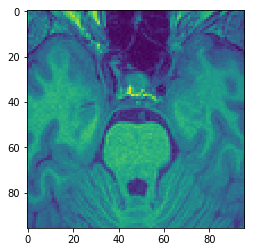

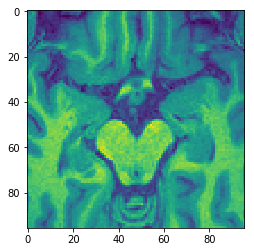

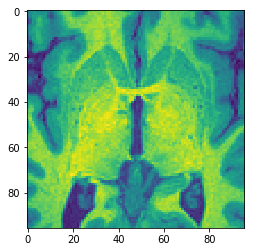

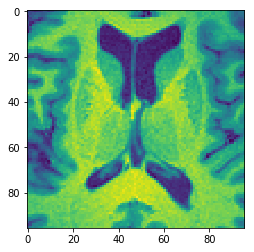

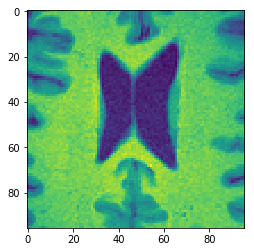

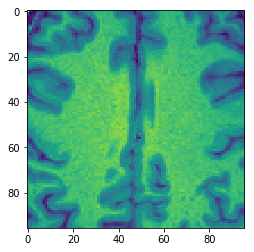

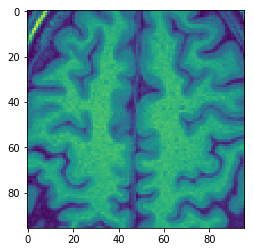

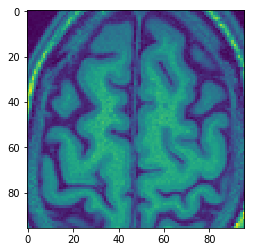

In [12]:
train_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)
imgs, labels = next(iter(train_loader))
print(imgs.size())
print(imgs[0].squeeze(0).size())
scan = imgs[0].squeeze(0).numpy()
print(scan.shape)
for i in range(0, 48, 6):
    plt.imshow(scan[i])
    plt.show()

In [13]:
from torch.autograd import Variable

def train(model, features_list, num_epochs=2, batch_size=16, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    # use Adam for CNN
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    epochs, train_losses, valid_losses, train_acc, valid_acc = [], [], [], [], []
    
    train_loader = torch.utils.data.DataLoader(features_list, batch_size=batch_size, shuffle=True)
    
    loss = 0
    
    for epoch in range(num_epochs):
        for inputs, labels in iter(train_loader):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            #print(torch.sum(inputs))
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=True)
            optimizer.step()
            #for param in model.parameters():
            #  print(param.grad.data.sum())
    
        epochs.append(epoch)
        #train_losses.append(loss)
        train_losses.append(get_loss(model, train=True))
        valid_losses.append(get_loss(model, train=False))
        train_acc.append(get_accuracy(model, train=True))
        valid_acc.append(get_accuracy(model, train=False))
        
        print("Epoch %d; Train Loss %f; Val Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, valid_losses[-1], train_acc[-1], valid_acc[-1]))
        print(loss)
    
    plt.title("Training Curve")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))

In [14]:
class Paper3DCNN(nn.Module):
    def __init__(self):
        super(Paper3DCNN, self).__init__()
        self.name = "Paper3DCNN"
        # ?x1x96x96x48 to ?x32x96x96x48
        # kernel size is always 3 or 1 in vgg, stride is 1, padding is s.t. the resolution preserved after convolution
        # padding is 1 pixel for 3x3 convolution
        # max pooling 2, 2
        
        # first block
        self.conv1_1 = nn.Conv3d(1, 32, padding=1, kernel_size=3, bias=True)
        # max pool
        
        # second block
        self.conv2_1 = nn.Conv3d(32, 64, padding=1, kernel_size=3, bias=True)
        # max pool
        
        # third block
        self.conv3_1 = nn.Conv3d(64, 128, padding=1, kernel_size=3, bias=True)
        self.conv3_2 = nn.Conv3d(128, 128, padding=1, kernel_size=3, bias=True)
        # max pool
        
        # fourth block
        self.conv4_1 = nn.Conv3d(128, 256, padding=1, kernel_size=3, bias=True)
        self.conv4_2 = nn.Conv3d(256, 256, padding=1, kernel_size=3, bias=True)
        # max pool
        
        # fifth block
        self.conv5_1 = nn.Conv3d(256, 256, padding=1, kernel_size=3, bias=True)
        self.conv5_2 = nn.Conv3d(256, 256, padding=1, kernel_size=3, bias=True)
        # max pool 2
        
        self.maxpool1 = nn.MaxPool3d(2, 2)
        self.maxpool2 = nn.MaxPool3d(kernel_size=(2,2,2), padding=(1,0,0), stride=2)
        
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.fc3 = nn.Linear(10, 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        #residual = x
        
        # first block
        out = self.conv1_1(x)
        out = self.relu(out)
        out = self.maxpool1(out)
        #print(out.shape)
        
        # second block
        out = self.conv2_1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        #print(out.shape)

        # third block
        out = self.conv3_1(out)
        out = self.relu(out)
        out = self.conv3_2(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        #print(out.shape)

        # fourth block
        out = self.conv4_1(out)
        out = self.relu(out)
        out = self.conv4_2(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        #print(out.shape)
        
        # fourth block
        out = self.conv5_1(out)
        out = self.relu(out)
        out = self.conv5_2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #print(out.shape)

        # if self.downsample is not None:
        #     residual = self.downsample(x)

        #out += residual
        out = out.view(-1, 4608)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        #print(out.shape)

        return out

Epoch 1; Train Loss 0.705875; Val Loss 0.705679; Train Acc 0.250000; Val Acc 0.000000
tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 2; Train Loss 0.703519; Val Loss 0.703254; Train Acc 0.250000; Val Acc 0.000000
tensor(0.7035, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 3; Train Loss 0.700820; Val Loss 0.700520; Train Acc 0.250000; Val Acc 0.000000
tensor(0.7008, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 4; Train Loss 0.693156; Val Loss 0.697325; Train Acc 0.250000; Val Acc 0.000000
tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 5; Train Loss 0.694616; Val Loss 0.694351; Train Acc 0.250000; Val Acc 0.000000
tensor(0.6946, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 6; Train Loss 0.692215; Val Loss 0.691912; Train Acc 0.750000; Val Acc 1.000000
tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch 7; Train Loss 0.693157; Val Loss 0.688766; Train Acc 0.750000; Val Acc 1.000000
tensor(0.6932, device='cuda:0', grad_fn=<Nll

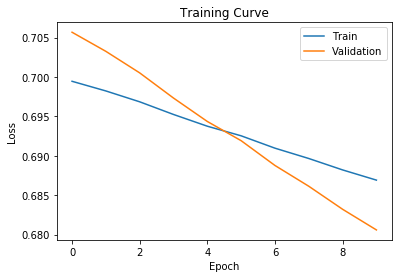

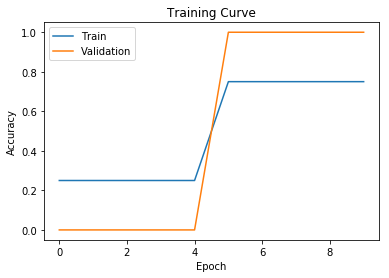

Final Training Accuracy: 0.75
Final Validation Accuracy: 1.0


In [15]:
paper_model = Paper3DCNN()
paper_model.cuda()
train(paper_model, train_dataset, num_epochs=25, batch_size=2, learning_rate=1e-4)

In [ ]:
inlayer = torch.randn([8,256,3,6,6])
maxpool = nn.MaxPool3d(kernel_size=(2,2,2), padding=(1,0,0), stride=2)
layer = maxpool(inlayer)
print(layer.shape)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for param in paper_model.parameters():
    print(param.grad.data.sum())

In [17]:
get_accuracy(paper_model, train=False)

0.7777777777777778

In [ ]:
output = paper_model()